In [12]:
# MTF072 Computational Fluid Dynamics
# Task 3: laminar lid-driven cavity
# Template prepared by:
# Gonzalo Montero Villar
# Department of Mechanics and Maritime Sciences
# Division of Fluid Dynamics
# December 2020

#==============Packages needed=================
import matplotlib.pyplot as plt
import cupy as np
from cupyx.scipy.sparse import linalg
from cupyx.scipy import sparse
import matplotlib as mpl
import line_profiler as lp
from numba import cuda
import numpy


lineProfiler = lp.LineProfiler() #Initialize profiler

In [13]:
#================= Functions ==================
def rhieChow(aPe,aPw,aPn,aPs,rho,U,V,P,dx_CV,dy_CV,fxe,fxw,fyn,fys,coeffsUV,nI,nJ,Fe,Fw,Fn,Fs):

    aPe[1:nI-1,1:nJ-1] = ((fxe[1:nI-1,1:nJ-1] * coeffsUV[2:nI,1:nJ-1,4]) + (1 - fxe[1:nI-1,1:nJ-1])*coeffsUV[1:nI-1,1:nJ-1,4])
    aPw[1:nI-1,1:nJ-1] = ((fxw[1:nI-1,1:nJ-1] * coeffsUV[0:nI-2,1:nJ-1,4]) + (1 - fxw[1:nI-1,1:nJ-1])*coeffsUV[1:nI-1,1:nJ-1,4])
    aPn[1:nI-1,1:nJ-1] = ((fyn[1:nI-1,1:nJ-1] * coeffsUV[1:nI-1,2:nJ,4]) + (1 - fyn[1:nI-1,1:nJ-1])*coeffsUV[1:nI-1,1:nJ-1,4])
    aPs[1:nI-1,1:nJ-1] = ((fys[1:nI-1,1:nJ-1] * coeffsUV[1:nI-1,0:nJ-2,4]) + (1 - fys[1:nI-1,1:nJ-1])*coeffsUV[1:nI-1,1:nJ-1,4])
    
    Fe[1:nI-2,1:nJ-1] =  ((fxe[1:nI-2,1:nJ-1] * U[2:nI-1,1:nJ-1] + (1 - fxe[1:nI-2,1:nJ-1])*U[1:nI-2,1:nJ-1]) + dy_CV[1:nI-2,1:nJ-1]/(4*aPe[1:nI-2,1:nJ-1])*(P[3:nI,1:nJ-1] - 3*P[2:nI-1,1:nJ-1] + 3*P[1:nI-2,1:nJ-1] - P[0:nI-3,1:nJ-1]))*rho * dy_CV[1:nI-2,1:nJ-1] # east convective
    Fe[nI-2,1:nJ-1] =  (fxe[nI-2,1:nJ-1] * U[nI-1,1:nJ-1] + (1 - fxe[nI-2,1:nJ-1])*U[nI-2,1:nJ-1]) * rho * dy_CV[nI-2,1:nJ-1]

    Fw[2:nI-1,1:nJ-1] =  ((fxw[2:nI-1,1:nJ-1] * U[1:nI-2,1:nJ-1] + (1 - fxw[2:nI-1,1:nJ-1])*U[2:nI-1,1:nJ-1]) + dy_CV[2:nI-1,1:nJ-1]/(4*aPw[2:nI-1,1:nJ-1])*(P[3:nI,1:nJ-1] - 3*P[2:nI-1,1:nJ-1] + 3*P[1:nI-2,1:nJ-1] - P[0:nI-3,1:nJ-1]))*rho * dy_CV[2:nI-1,1:nJ-1] # west convective
    Fw[1,1:nJ-1] =  (fxw[1,1:nJ-1] * U[0,1:nJ-1] + (1 - fxw[1,1:nJ-1])*U[1,1:nJ-1]) * rho * dy_CV[1,1:nJ-1]  

    Fn[1:nI-1,1:nJ-2] =  ((fyn[1:nI-1,1:nJ-2] * V[1:nI-1,2:nJ-1] + (1 - fyn[1:nI-1,1:nJ-2])*V[1:nI-1,1:nJ-2]) + dx_CV[1:nI-1,1:nJ-2]/(4*aPn[1:nI-1,1:nJ-2])*(P[1:nI-1,3:nJ] - 3*P[1:nI-1,2:nJ-1] + 3*P[1:nI-1,1:nJ-2] - P[1:nI-1,0:nJ-3]))*rho * dx_CV[1:nI-1,1:nJ-2] # north convective
    Fn[1:nI-1,nJ-2] =  (fyn[1:nI-1,nJ-2] * V[1:nI-1,nJ-1] + (1 - fyn[1:nI-1,nJ-2])*V[1:nI-1,nJ-2]) * rho * dx_CV[1:nI-1,nJ-2] 

    Fs[1:nI-1,2:nJ-1] =  ((fys[1:nI-1,2:nJ-1] * V[1:nI-1,1:nJ-2] + (1 - fys[1:nI-1,2:nJ-1])*V[1:nI-1,2:nJ-1]) + dx_CV[1:nI-1,2:nJ-1]/(4*aPs[1:nI-1,2:nJ-1])*(P[1:nI-1,3:nJ] - 3*P[1:nI-1,2:nJ-1] + 3*P[1:nI-1,1:nJ-2] - P[1:nI-1,0:nJ-3]))*rho * dx_CV[1:nI-1,2:nJ-1] # south convective
    Fs[1:nI-1,1] =  (fys[1:nI-1,1] * V[1:nI-1,0] + (1 - fys[1:nI-1,1])*V[1:nI-1,1]) * rho * dx_CV[1:nI-1,1]
                
    #return [Fe,Fw,Fn,Fs]

def solve(field,coeffs,source,nI,nJ,solver):

    if solver == 'Jacobi':
        for iter in range(0,10):
           field[1:nI-1,1:nJ-1] = 1/coeffs[1:nI-1,1:nJ-1,4]*(coeffs[1:nI-1,1:nJ-1,0]*field[2:nI,1:nJ-1] + coeffs[1:nI-1,1:nJ-1,1]*field[0:nI-2,1:nJ-1] + coeffs[1:nI-1,1:nJ-1,2]*field[1:nI-1,2:nJ] + coeffs[1:nI-1,1:nJ-1,3]*field[1:nI-1,0:nJ-2] + source[1:nI-1,1:nJ-1])

    elif solver == 'Gauss-Seidel':
        for iter in range(0,10):
            # Gauss-Seidel method
            for i in range(1,nI-1):
                for j in range(1,nJ-1):
                    field[i,j] = 1/coeffs[i,j,4]*(coeffs[i,j,0]*field[i+1,j] + coeffs[i,j,1]*field[i-1,j] + coeffs[i,j,2]*field[i,j+1] + coeffs[i,j,3]*field[i,j-1] + source[i,j])
    else:

        tol_conv = 1e-5 # 1e-3 for pp
        nmax = 50

        ae=np.ravel(coeffs[:,:,0])
        aw=np.ravel(coeffs[:,:,1])
        an=np.ravel(coeffs[:,:,2])
        as1=np.ravel(coeffs[:,:,3])
        ap=np.ravel(coeffs[:,:,4])
        
        A = sparse.diags([ap, -an[0:-1], -as1[1:], -ae, -aw[nJ:]], [0, 1, -1, nJ, -(nJ)], format='csr')
        su=np.ravel(source)
        phi=np.ravel(field)

        info = 0
        if solver == 'cgs':
            phi,info=linalg.cgs(A,su,x0=phi, tol=tol_conv, atol=tol_conv,  maxiter=nmax)  # good
        elif solver == 'cg':
            phi,info=linalg.cg(A,su,x0=phi, tol=tol_conv, atol=tol_conv,  maxiter=nmax)  # good
        elif solver == 'gmres':
            phi,info=linalg.gmres(A,su,x0=phi, tol=tol_conv, atol=tol_conv,  maxiter=nmax)  # good
        elif solver == 'qmr':
            phi,info=linalg.qmr(A,su,x0=phi, tol=tol_conv, atol=tol_conv,  maxiter=nmax)  # good
        elif solver == 'lgmres':
            phi,info=linalg.lgmres(A,su,x0=phi, tol=tol_conv, atol=tol_conv,  maxiter=nmax)  # good
        
        if info > 0:
            print('warning in module solve_2d: convergence in sparse matrix solver not reached')

        field = np.reshape(phi,(nI,nJ))
    return field


def setBc(Sp,Su,coeffs,viscos,bcs):

    # East
    Sp[-2,:] -= 1*coeffs[-2,:,0]
    Su[-2,:,1] += 1*coeffs[-2,:,0]*bcs[0]

    # West
    Sp[1,:] -= 1*coeffs[1,:,1]
    Su[1,:,1] += 1*coeffs[1,:,1]*bcs[1]

    # North
    Sp[:,-2] -= 1*coeffs[:,-2,2]
    Su[:,-2,0] += 1*coeffs[:,-2,2]*bcs[2]

    # South
    Sp[:,1] -= 1*coeffs[:,1,3]
    Su[:,1,0] += 1*coeffs[:,1,3]*bcs[3]


    return Su, Sp
    
def main(mI,mJ,xL,yL,mu,UWall,nIterations,alphaUV,rho,alphaP,resTolerance,solver):
    # For all the matrices the first input makes reference to the x coordinate
    # and the second input to the y coordinate, (i+1) is east and (j+1) north

    # Allocate all needed variables
    nI = mI + 1                      # number of nodes in the X direction. nodes 
                                    # added in the boundaries
    nJ = mJ + 1                      # number of nodes in the Y direction. nodes 
                                    # added in the boundaries
    coeffsUV   = np.zeros((nI,nJ,5)) # coefficients for the U and V equation
                                    # E, W, N, S and P
    sourceUV   = np.zeros((nI,nJ,2)) # source coefficients for the U and V equation
                                    # U and V
    coeffsPp   = np.zeros((nI,nJ,5)) # coefficients for the pressure correction
                                    # equation E, W, N, S and P
    sourcePp   = np.zeros((nI,nJ))   # source coefficients for the pressure
                                    # correction equation
    U          = np.zeros((nI,nJ))   # U velocity matrix
    V          = np.zeros((nI,nJ))   # V velocity matrix
    P          = np.zeros((nI,nJ))   # pressure matrix
    Pp         = np.zeros((nI,nJ))   # pressure correction matrix

    residuals  = np.zeros((3,nIterations))     # U, V and conitnuity residuals
    residuals_U = []
    residuals_V = []
    residuals_c = []

    # Generate mesh and compute geometric variables

    # Allocate all variables matrices
    xCoords_N = np.zeros((nI,nJ)) # X coords of the nodes
    yCoords_N = np.zeros((nI,nJ)) # Y coords of the nodes
    dxe_N     = np.zeros((nI,nJ)) # X distance to east node
    dxw_N     = np.zeros((nI,nJ)) # X distance to west node
    dyn_N     = np.zeros((nI,nJ)) # Y distance to north node
    dys_N     = np.zeros((nI,nJ)) # Y distance to south node
    dx_CV      = np.zeros((nI,nJ)) # X size of the node
    dy_CV      = np.zeros((nI,nJ)) # Y size of the node

    fxe = np.zeros((nI,nJ))
    fxw = np.zeros((nI,nJ))
    fyn = np.zeros((nI,nJ))
    fys = np.zeros((nI,nJ))

    Fe = np.zeros((nI,nJ))
    Fw = np.zeros((nI,nJ))
    Fn = np.zeros((nI,nJ))
    Fs = np.zeros((nI,nJ))

    De = np.zeros((nI,nJ))
    Dw = np.zeros((nI,nJ))
    Dn = np.zeros((nI,nJ))
    Ds = np.zeros((nI,nJ))

    pGradE = np.zeros((nI,nJ))
    pGradW = np.zeros((nI,nJ))
    pGradN = np.zeros((nI,nJ))
    pGradS = np.zeros((nI,nJ))

    tempZeroes = np.zeros((nI,nJ))

    dx = xL/(mI - 1)
    dy = yL/(mJ - 1)

    # Fill the coordinates
    xTemp = np.arange(0,mI)*dx
    yTemp = np.arange(0,mJ)*dy
    xCoords_M, yCoords_M = np.meshgrid(xTemp,yTemp,indexing='ij')

    # For the nodes
    xCoords_N[1:mI,0:mJ] = 0.5*(xCoords_M[1:mI,0:mJ] + xCoords_M[0:mI-1,0:mJ])
    xCoords_N[1:mI,mJ] = 0.5*(xCoords_M[1:mI,mJ-1] + xCoords_M[0:mI-1,mJ-1])

    yCoords_N[0:mI,1:mJ] = 0.5*(yCoords_M[0:mI,1:mJ] + yCoords_M[0:mI,0:mJ-1])
    yCoords_N[mI,1:mJ] = 0.5*(yCoords_M[mI-1,1:mJ] + yCoords_M[mI-1,0:mJ-1])
    
    # Fill dx_CV and dy_CV
    dx_CV[1:mI,0:mJ] = xCoords_M[1:mI,0:mJ] - xCoords_M[0:mI-1,0:mJ]
    dy_CV[0:mI,1:mJ] = yCoords_M[0:mI,1:mJ] - yCoords_M[0:mI,0:mJ-1]
    xCoords_N[-1,:] = xL
    yCoords_N[:,-1] = yL


    # Fill dxe, dxw, dyn and dys
    dxe_N[1:nI-1,1:nJ-1] = xCoords_N[2:nI,1:nJ-1] - xCoords_N[1:nI-1,1:nJ-1]
    dxw_N[1:nI-1,1:nJ-1] = xCoords_N[1:nI-1,1:nJ-1] - xCoords_N[0:nI-2,1:nJ-1]
    dyn_N[1:nI-1,1:nJ-1] = yCoords_N[1:nI-1,2:nJ] - yCoords_N[1:nI-1,1:nJ-1]
    dys_N[1:nI-1,1:nJ-1] = yCoords_N[1:nI-1,1:nJ-1] - yCoords_N[1:nI-1,0:nJ-2]

    # Initialize variable matrices
    U[:,:] = 0
    V[:,:] = 0
    P[:,:] = 0

    # Compute f and D
    fxe[1:nI-1,1:nJ-1] = 0.5*dx_CV[1:nI-1,1:nJ-1]/dxe_N[1:nI-1,1:nJ-1]
    fxw[1:nI-1,1:nJ-1] = 0.5*dx_CV[1:nI-1,1:nJ-1]/dxw_N[1:nI-1,1:nJ-1]
    fyn[1:nI-1,1:nJ-1] = 0.5*dy_CV[1:nI-1,1:nJ-1]/dyn_N[1:nI-1,1:nJ-1]
    fys[1:nI-1,1:nJ-1] = 0.5*dy_CV[1:nI-1,1:nJ-1]/dys_N[1:nI-1,1:nJ-1]

    De[1:nI-1,1:nJ-1] = dy_CV[1:nI-1,1:nJ-1]*mu/dxe_N[1:nI-1,1:nJ-1]
    Dw[1:nI-1,1:nJ-1] = dy_CV[1:nI-1,1:nJ-1]*mu/dxw_N[1:nI-1,1:nJ-1]
    Dn[1:nI-1,1:nJ-1] = dx_CV[1:nI-1,1:nJ-1]*mu/dyn_N[1:nI-1,1:nJ-1]
    Ds[1:nI-1,1:nJ-1] = dx_CV[1:nI-1,1:nJ-1]*mu/dys_N[1:nI-1,1:nJ-1]
    
    # Set bcs
    #bcs = np.array([0,0,UWall,0])
    U[:,nJ-1] = UWall
    # Looping
    for iter in range(nIterations):
        # Compute Sp
        Sp = Fw - Fe + Fs - Fn

        ## Compute coefficients for inner nodes
        coeffsUV[1:nI-1,1:nJ-1,0] = De[1:nI-1,1:nJ-1] + np.maximum(tempZeroes[1:nI-1,1:nJ-1],-Fe[1:nI-1,1:nJ-1])
        coeffsUV[1:nI-1,1:nJ-1,1] = Dw[1:nI-1,1:nJ-1] + np.maximum(tempZeroes[1:nI-1,1:nJ-1],Fw[1:nI-1,1:nJ-1])
        coeffsUV[1:nI-1,1:nJ-1,2] = Dn[1:nI-1,1:nJ-1] + np.maximum(tempZeroes[1:nI-1,1:nJ-1],-Fn[1:nI-1,1:nJ-1])
        coeffsUV[1:nI-1,1:nJ-1,3] = Ds[1:nI-1,1:nJ-1] + np.maximum(tempZeroes[1:nI-1,1:nJ-1],Fs[1:nI-1,1:nJ-1])

        ## Compute source terms for inner nodes
        ## Räkna ut tryck-gradient på faces och sätt Neumann på boundaries
        sourceUV[1:nI-1,1:nJ-1,0] = -0.5*(P[2:nI,1:nJ-1] - P[0:nI-2,1:nJ-1])*dy_CV[1:nI-1,1:nJ-1] + np.maximum(Sp[1:nI-1,1:nJ-1],tempZeroes[1:nI-1,1:nJ-1])*U[1:nI-1,1:nJ-1]
        sourceUV[1:nI-1,1:nJ-1,1] = -0.5*(P[1:nI-1,2:nJ] - P[1:nI-1,0:nJ-2])*dx_CV[1:nI-1,1:nJ-1] + np.maximum(Sp[1:nI-1,1:nJ-1],tempZeroes[1:nI-1,1:nJ-1])*V[1:nI-1,1:nJ-1]
        Sp[1:nI-1,1:nJ-1] = -np.maximum(-Sp[1:nI-1,1:nJ-1],tempZeroes[1:nI-1,1:nJ-1])

        # ## Set bcs through source terms
        # sourceUV, Sp = setBc(Sp,sourceUV,coeffsUV,mu,bcs)
        # coeffsUV[:,-2,0] = 0
        # coeffsUV[:,1,1] = 0
        # coeffsUV[-2,:,2] = 0
        # coeffsUV[1,:,3] = 0

        ## Compute aP and introduce implicit under-relaxation for U and V
        coeffsUV[:,:,4] = (coeffsUV[:,:,0] + coeffsUV[:,:,1] + coeffsUV[:,:,2] + coeffsUV[:,:,3] - Sp[:,:])/alphaUV
        sourceUV[:,:,0] += (1-alphaUV)*coeffsUV[:,:,4]*U
        sourceUV[:,:,1] += (1-alphaUV)*coeffsUV[:,:,4]*V

            
        ## Solve for U and V 
        U = solve(U,coeffsUV,sourceUV[:,:,0],nI,nJ,solver)
        V = solve(V,coeffsUV,sourceUV[:,:,1],nI,nJ,solver)
        
        aPe = np.zeros((nI,nJ))
        aPw = np.zeros((nI,nJ))
        aPn = np.zeros((nI,nJ))
        aPs = np.zeros((nI,nJ))
            
        ## Calculate at the faces using Rhie-Chow for the face velocities
        rhieChow(aPe,aPw,aPn,aPs,rho,U,V,P,dx_CV,dy_CV,fxe,fxw,fyn,fys,coeffsUV,nI,nJ,Fe,Fw,Fn,Fs)
        

        ## Calculate pressure correction equation coefficients
        coeffsPp[1:nI-2,1:nJ-1,0] = dy_CV[1:nI-2,1:nJ-1]**2*rho/(fxe[1:nI-2,1:nJ-1] * coeffsUV[2:nI-1,1:nJ-1,4] + (1 - fxe[1:nI-2,1:nJ-1])*coeffsUV[1:nI-2,1:nJ-1,4])
        coeffsPp[nI-2,1:nJ-1,0] = 0

        coeffsPp[2:nI-1,1:nJ-1,1] = dy_CV[2:nI-1,1:nJ-1]**2*rho/(fxw[2:nI-1,1:nJ-1] * coeffsUV[1:nI-2,1:nJ-1,4] + (1 - fxw[2:nI-1,1:nJ-1])*coeffsUV[2:nI-1,1:nJ-1,4])
        coeffsPp[1,1:nJ-1,1] = 0

        coeffsPp[1:nI-1,1:nJ-2,2] = dx_CV[1:nI-1,1:nJ-2]**2*rho/(fyn[1:nI-1,1:nJ-2] * coeffsUV[1:nI-1,2:nJ-1,4] + (1 - fyn[1:nI-1,1:nJ-2])*coeffsUV[1:nI-1,1:nJ-2,4])
        coeffsPp[1:nI-1,nJ-2,2] = 0

        coeffsPp[1:nI-1,2:nJ-1,3] = dx_CV[1:nI-1,2:nJ-1]**2*rho/(fys[1:nI-1,2:nJ-1] * coeffsUV[1:nI-1,1:nJ-2,4] + (1 - fys[1:nI-1,2:nJ-1])*coeffsUV[1:nI-1,2:nJ-1,4])
        coeffsPp[1:nI-1,1,3] = 0
        
        sourcePp = Fw - Fe + Fs - Fn
        Spp = np.zeros([nI,nJ])
        coeffsPp[:,:,4] = coeffsPp[:,:,0] + coeffsPp[:,:,1] + coeffsPp[:,:,2] + coeffsPp[:,:,3] - Spp[:,:]


        # Solve for pressure correction (Note that more that one loop is used)
        Pp[:,:] = 0
        Pp = solve(Pp,coeffsPp,sourcePp,nI,nJ,solver)
                
        # Set Pp with reference to node (2,2) and copy to boundaries
        Pp = Pp - Pp[1,1]
        
        # Correct velocities, pressure and mass flows
        P += alphaP*Pp
        
        P[nI-1,1:nJ-1] = P[nI-2,1:nJ-1] + pGradE[nI-3,1:nJ-1]*dxe_N[nI-2,1:nJ-1]
        P[0,nJ-1] = P[1,nJ-1] + pGradW[2,nJ-1]*dxw_N[1,nJ-1]
        P[1:nI-1,nJ-1] = P[1:nI-1,nJ-2] + pGradN[1:nI-1,nJ-3]*dyn_N[1:nI-1,nJ-2]
        P[1:nI-1,0] = P[1:nI-1,1] + pGradN[1:nI-1,2]*dys_N[1:nI-1,1] 
            
        U[1:nI-1,1:nJ-1] -= 0.5*(Pp[2:nI,1:nJ-1] - Pp[0:nI-2,1:nJ-1]) * dy_CV[1:nI-1,1:nJ-1] / coeffsUV[1:nI-1,1:nJ-1,4]
        V[1:nI-1,1:nJ-1] -= 0.5*(Pp[1:nI-1,2:nJ] - Pp[1:nI-1,0:nJ-2]) * dy_CV[1:nI-1,1:nJ-1] / coeffsUV[1:nI-1,1:nJ-1,4]

        rhieChow(aPe,aPw,aPn,aPs,rho,U,V,P,dx_CV,dy_CV,fxe,fxw,fyn,fys,coeffsUV,nI,nJ,Fe,Fw,Fn,Fs)
        


        # Compute residuals Ver 2
        residuals[0,iter] = np.linalg.norm(coeffsUV[1:nI-1,1:nJ-1,4]*U[1:nI-1,1:nJ-1] - (coeffsUV[1:nI-1,1:nJ-1,0]*U[2:nI,1:nJ-1] + coeffsUV[1:nI-1,1:nJ-1,1]*U[0:nI-2,1:nJ-1] + coeffsUV[1:nI-1,1:nJ-1,2]*U[1:nI-1,2:nJ] + coeffsUV[1:nI-1,1:nJ-1,3]*U[1:nI-1,0:nJ-2] + sourceUV[1:nI-1,1:nJ-1,0]),1)
        residuals[1,iter] = np.linalg.norm(coeffsUV[1:nI-1,1:nJ-1,4]*V[1:nI-1,1:nJ-1] - (coeffsUV[1:nI-1,1:nJ-1,0]*V[2:nI,1:nJ-1] + coeffsUV[1:nI-1,1:nJ-1,1]*V[0:nI-2,1:nJ-1] + coeffsUV[1:nI-1,1:nJ-1,2]*V[1:nI-1,2:nJ] + coeffsUV[1:nI-1,1:nJ-1,3]*V[1:nI-1,0:nJ-2] + sourceUV[1:nI-1,1:nJ-1,1]),1)
        residuals[2,iter] = np.linalg.norm(Fw[1:nI-1,1:nJ-1] - Fe[1:nI-1,1:nJ-1] + Fs[1:nI-1,1:nJ-1] - Fn[1:nI-1,1:nJ-1],1)
        
        print('iteration: %d\nresU = %.5e, resV = %.5e, resCon = %.5e\n\n'\
           % (iter, residuals[0,iter], residuals[1,iter], residuals[2,iter]))


        if np.greater(resTolerance,np.max(residuals[:,iter])):
           break


    return U,V,P,nI,nJ,xCoords_N,yCoords_N, residuals, iter

In [14]:
#================= Inputs =====================

# Fluid properties and B. C. inputs

UWall = 1 # velocity of the upper wall
rho   = 1 # density
nu    = 1/1000 # kinematic viscosity
mu = nu*rho    # dynamics viscosity

data_file = open ('data_FOU_CD.txt')# data file where the given solution is stored

# Geometric inputs (fixed so that a fair comparison can be made)

mI = 1001 # number of mesh points X direction. 
mJ = 1001 # number of mesh points Y direction. 
xL =  1 # length in X direction
yL =  1 # length in Y direction

# Solver inputs
nIterations           = 10 # maximum number of iterations
# Solvers: cgs, cg, gmres, qmr, lgmres, Jacobi, Gauss-Seidel
solver = 'Jacobi'
                              # pressure correction with Gauss-Seidel
resTolerance = 1e-7 # convergence criteria for residuals
                     # each variable
alphaUV = 0.5       # under relaxation factor for U and V
alphaP  = 0.5       # under relaxation factor for P

plotting = 1

In [15]:
# ============ Run Solver ===============

profiler_wrapper = lineProfiler(main) #Create a wrapper for the function to be profiled
U,V,P,nI,nJ,xCoords_N,yCoords_N,residuals,iterEnd = profiler_wrapper(mI,mJ,xL,yL,mu,UWall,nIterations,alphaUV,rho,alphaP,resTolerance,solver) #Call the wrapper

lineProfiler.print_stats() #Print the results

iteration: 0
resU = 4.28473e-03, resV = 2.71106e-03, resCon = 4.26977e-03


iteration: 1
resU = 4.07199e-03, resV = 2.85255e-03, resCon = 4.65188e-03


iteration: 2
resU = 2.57909e-03, resV = 2.40919e-03, resCon = 3.80858e-03


iteration: 3
resU = 1.43444e-03, resV = 1.98156e-03, resCon = 2.70353e-03


iteration: 4
resU = 9.41458e-04, resV = 1.70251e-03, resCon = 2.36700e-03


Timer unit: 1e-07 s

Total time: 0.332455 s
File: C:\Users\pontu\AppData\Local\Temp\ipykernel_4064\1457829895.py
Function: main at line 90

Line #      Hits         Time  Per Hit   % Time  Line Contents
    90                                           def main(mI,mJ,xL,yL,mu,UWall,nIterations,alphaUV,rho,alphaP,resTolerance,solver):
    91                                               # For all the matrices the first input makes reference to the x coordinate
    92                                               # and the second input to the y coordinate, (i+1) is east and (j+1) north
    93                        

C:\Users\pontu\AppData\Local\Temp\ipykernel_4064\1049406702.py:22: RuntimeWarning: invalid value encountered in scalar divide
  U_norm[i,j] = U[i,j] / UVvec[i,j]
C:\Users\pontu\AppData\Local\Temp\ipykernel_4064\1049406702.py:23: RuntimeWarning: invalid value encountered in scalar divide
  V_norm[i,j] = V[i,j] / UVvec[i,j]


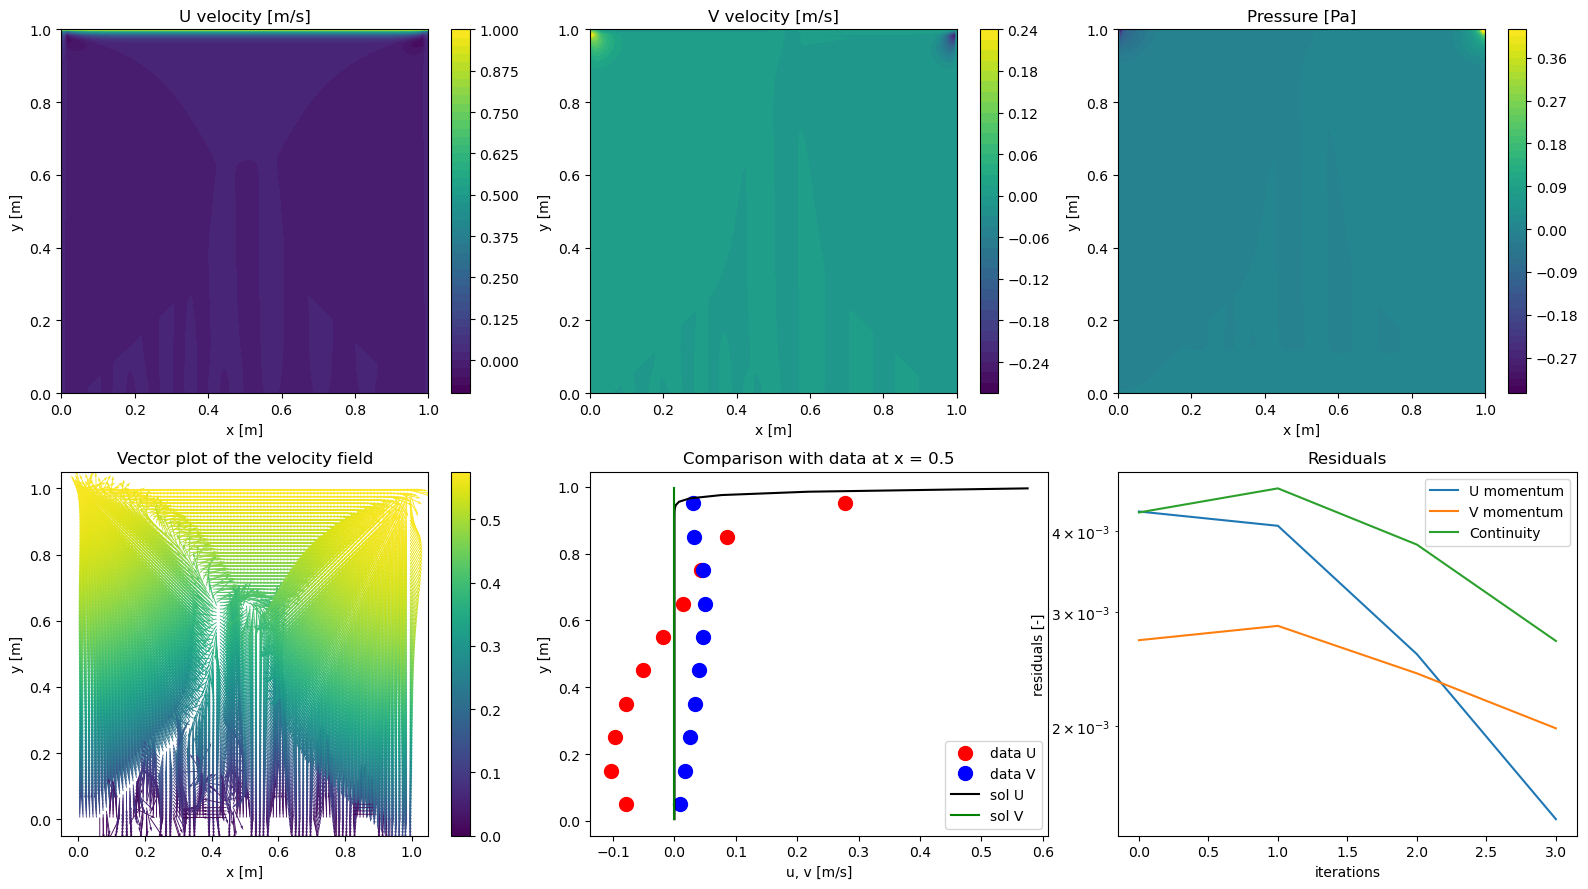

In [16]:
# ============== Plotting =================

# Covert from cupy to numpy
U = np.asnumpy(U)
V = np.asnumpy(V)
P = np.asnumpy(P)
nI = np.asnumpy(nI)
nJ = np.asnumpy(nJ)
xCoords_N = np.asnumpy(xCoords_N)
yCoords_N = np.asnumpy(yCoords_N)
residuals = np.asnumpy(residuals)

if plotting == 1:
    U[:,nJ-1] = UWall
    #Velocity Vector normalization for plotting
    UVvec = numpy.zeros((nI,nJ))
    U_norm = numpy.zeros((nI,nJ))
    V_norm = numpy.zeros((nI,nJ))
    for i in range(1,nI-1):
        for j in range(1,nJ-1):
            UVvec[i,j] =numpy.sqrt(pow(U[i,j],2) + pow(V[i,j],2))
            U_norm[i,j] = U[i,j] / UVvec[i,j]
            V_norm[i,j] = V[i,j] / UVvec[i,j]



    # Plot results
    plt.figure(1, figsize=(16,9))

    # U velocity contour
    plt.subplot(2,3,1)
    csu=plt.contourf(xCoords_N,yCoords_N,U,50)
    plt.colorbar(csu)
    plt.title('U velocity [m/s]')
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.tight_layout()

    # V velocity contour
    plt.subplot(2,3,2)
    csv=plt.contourf(xCoords_N,yCoords_N,V,50)
    plt.colorbar(csv)
    plt.title('V velocity [m/s]')
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.tight_layout()

    # P contour
    plt.subplot(2,3,3)
    csp=plt.contourf(xCoords_N,yCoords_N,P,50)
    plt.colorbar(csp)
    plt.title('Pressure [Pa]')
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.tight_layout()

    # Vector plot
    plt.subplot(2,3,4)
    norm = mpl.colors.LogNorm()
    concat_UVvec=numpy.concatenate(UVvec)
    norm.autoscale(concat_UVvec)
    colormap=mpl.cm.viridis
    pcm=plt.quiver(xCoords_N, yCoords_N, U_norm, V_norm, color=colormap(norm(concat_UVvec)),scale=15)
    plt.colorbar(pcm)
    #plt.quiverkey(pcm, 0.765, 0.9, 1, '$m/s$',labelpos='E',coordinates='figure')
    plt.clim(UVvec.min(),UVvec.max())
    plt.title('Vector plot of the velocity field')
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.tight_layout()

    # Comparison with data
    data=numpy.genfromtxt(data_file, skip_header=1)
    uInterp = numpy.zeros((nJ-2,1))
    vInterp = numpy.zeros((nJ-2,1))
    for j in range(1,nJ-1):
        for i in range(1,nI-1):
            if xCoords_N[i,j]<0.5 and xCoords_N[i+1,j]>0.5:
                uInterp[j-1] = (U[i+1,j] + U[i,j])*0.5
                vInterp[j-1] = (V[i+1,j] + V[i,j])*0.5
                break
            elif abs(xCoords_N[i,j]-0.5) < 0.000001:
                uInterp[j-1] = U[i,j]
                vInterp[j-1] = V[i,j]
                break

    plt.subplot(2,3,5)
    plt.plot(data[:,0],data[:,2],'r.',markersize=20,label='data U')
    plt.plot(data[:,1],data[:,2],'b.',markersize=20,label='data V')
    plt.plot(uInterp,yCoords_N[1,1:-1],'k',label='sol U')
    plt.plot(vInterp,yCoords_N[1,1:-1],'g',label='sol V')
    plt.title('Comparison with data at x = 0.5')
    plt.xlabel('u, v [m/s]')
    plt.ylabel('y [m]')
    plt.legend()

    plt.subplot(2,3,6)
    plt.plot(residuals[0,:iterEnd], label='U momentum')
    plt.plot(residuals[1,:iterEnd], label='V momentum')
    plt.plot(residuals[2,:iterEnd], label='Continuity')
    plt.title('Residual convergence')
    plt.xlabel('iterations')
    plt.ylabel('residuals [-]')
    plt.legend()
    plt.title('Residuals')
    plt.yscale('log')

    plt.show()
    #plt.close()
elif plotting == 2:
    # Comparison with data
    data=numpy.genfromtxt(data_file, skip_header=1)
    uInterp = numpy.zeros((nJ-2,1))
    vInterp = numpy.zeros((nJ-2,1))
    for j in range(1,nJ-1):
        for i in range(1,nI-1):
            if xCoords_N[i,j]<0.5 and xCoords_N[i+1,j]>0.5:
                uInterp[j-1] = (U[i+1,j] + U[i,j])*0.5
                vInterp[j-1] = (V[i+1,j] + V[i,j])*0.5
                break
            elif abs(xCoords_N[i,j]-0.5) < 0.000001:
                uInterp[j-1] = U[i,j]
                vInterp[j-1] = V[i,j]
                break

    plt.figure(1)
    plt.plot(data[:,0],data[:,2],'r.',markersize=20,label='data U')
    plt.plot(data[:,1],data[:,2],'b.',markersize=20,label='data V')
    plt.plot(uInterp,yCoords_N[1,1:-1],'k',label='sol U')
    plt.plot(vInterp,yCoords_N[1,1:-1],'g',label='sol V')
    plt.title('Comparison with data at x = 0.5, Updated BCs')
    plt.xlabel('u, v [m/s]')
    plt.ylabel('y [m]')
    plt.legend()
    plt.savefig('updateSolver.png')

else:
    residuals_c = np.asnumpy(residuals[0,:])
    residuals_U = np.asnumpy(residuals[1,:])
    residuals_V = np.asnumpy(residuals[2,:])

    plt.figure(1)
    plt.plot(residuals_U, label='U momentum')
    plt.plot(residuals_V, label='V momentum')
    plt.plot(residuals_c, label='Continuity')
    plt.title('Residual convergence')
    plt.xlabel('iterations')
    plt.ylabel('residuals [-]')
    plt.legend()
    plt.title('Residuals')
    plt.yscale('log')